Author: Maxime Marin  
@: mff.marin@gmail.com

# Accessing IMOS data case studies: Walk-through and interactive session - Analysis

In this notebook, we will provide a receipe for further analysis to be done on the same dataset we selected earlier. In the future, a similar notebook can be tailored to a particular dataset, performing analysis that is easily repeatable.  
Alternatively, curious users can use the code to "tweak it" to their needs, and perform slightly different analysis and visualisation. This is why we have deliberately left some code in the cells, rather than hiding it.

As always, we start by importing our data and some main libraries


In [10]:
import sys
import os
sys.path.append('/home/jovyan/intake-aodn')
import intake_aodn
import matplotlib.pyplot as plt

from intake_aodn.plot import Clim_plot
from intake_aodn.analysis import lin_trend, make_clim

In [11]:
import xarray as xr
data = xr.open_dataset('Example_Data.nc')

***

## 1) Climatology

Calculating climatology of a particular variable is a very common operation performed in climate science. It allows to quantify the "mean" state of a particular variable and later substract it to the given variable to obtain anomalies.  

The most common climatology is done on a yearly timescale. It is equivalent to yearly average and is useful to calculate linear trends:

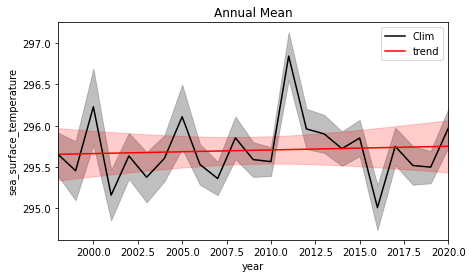

In [12]:
# We will work with the box-average timeseries:
data_bavg = data.stack(space=['longitude','latitude']).mean(dim='space')

# Perform and plot annual climatology
clim,ax = Clim_plot(da = data_bavg['sea_surface_temperature'],time_res = 'year')
ylab = ax.get_ylabel() # stores the y-axis label to re-use later.

# Calculate the linear trend and confidence interval
coef,fit,hci,lci = lin_trend(clim,'year')

# Plot the linear model
fit['linear_fit'].plot(ax=ax,color='red',label = 'trend')
plt.fill_between(lci['year'].values,lci['linear_fit'].values,hci['linear_fit'].values,alpha=0.2,color='red')

# add label, title and legend
ax.set_ylabel(ylab)
ax.set_title('Annual Mean')
plt.legend();

We have plotted the annual averages of box-averaged SST, along with the correspinding linear trend. However, something seems to be off..  

The first and last yearly values appear to be underestimated and overestimated, respectively. Why is that? (Hint: try to execute `clim.year[0]`, and `data.time[0]`. Hint 2: the access the last index of a list, we use the `[-1]`.) 

In [4]:
# type code here

The cell below outputs the same plot as before, but the 7th line is different. The function `Clim_plot()` takes `time_main` as an argument, which defines what time period we are interested in. Can we change line 7 to get a better plot?...

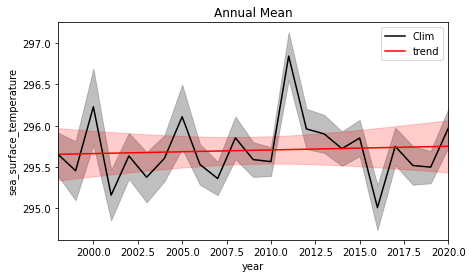

In [5]:
# We will work with the box-average timeseries:
data_bavg = data.stack(space=['longitude','latitude']).mean(dim='space')

# Perform and plot annual climatology
clim,ax = Clim_plot(da = data_bavg['sea_surface_temperature'],time_res = 'year',time_main = ['1992-01-01','2021-12-31'])
ylab = ax.get_ylabel() # stores the y-axis label to re-use later.

# Calculate the linear trend and confidence interval
coef,fit,hci,lci = lin_trend(clim,'year')

# Plot the linear model
fit['linear_fit'].plot(ax=ax,color='red',label = 'trend')
plt.fill_between(lci['year'].values,lci['linear_fit'].values,hci['linear_fit'].values,alpha=0.2,color='red')

# add label, title and legend
ax.set_ylabel(ylab)
ax.set_title('Annual Mean')
plt.legend();

***

## 2) Monthly climatology

Using the same function as before `Clim_plot` we can also calculate monthly climatology, which gives us the mean state of the variable for all months of the year.  
To do so, we just have to change the `time_res` argument such as `time_res = 'month'`

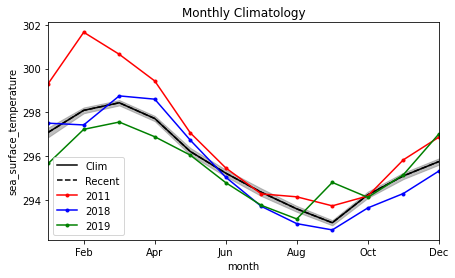

In [14]:
clim,ax = Clim_plot(data_bavg['sea_surface_temperature'],time_res = 'month',time_main = [data_bavg.time.min(),data_bavg.time.max()],time_recent = [data_bavg.time.min(), None],ind_yr = [2011,2018 ,2019])
ax.set_title('Monthly Climatology');

We notice that the function takes several other arguments than before, including `time_recent` and `ind_yr`.  
`time_recent` tells the function to also plot monthly climatology for a "more recent" time period, reflecting the recent mean state.  
` ind_yr` let the user chose individual years to plot. This is useful to compare one particular year with the average. For example, we clearly see that the 2011 summer was way warmer than usual!

Note: You can add these arguments if `time_res = 'year'`, but it will not do anything as it has no purpose for annual climatology.

*** 

## 3) Linear trends

It can also be useful to visualise the spatial distribution of long-term changes or trends. Rather than plotting a linear trend from one timeseries, let's calculate linear trend coefficients at all pixels and map it.

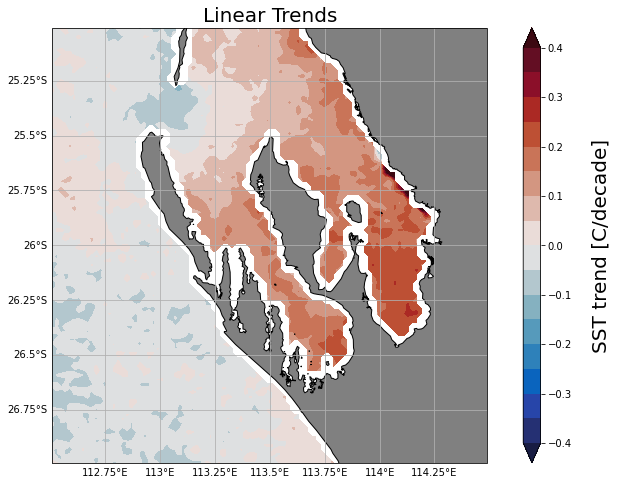

In [15]:
from intake_aodn.plot import map_var, create_cb
from intake_aodn.analysis import make_clim
import cmocean
import numpy as np

#First, we calculate yearly averages
clim = make_clim(data['sea_surface_temperature'],time_res = 'year')

#Then we can compute our linear models
coef,fit,hci,lci= lin_trend(clim[0],'year',deg=1)
#We rename a variable so that our plot makes more sense
coef = coef.rename({'polyfit_coefficients':'SST trend [C/decade]'})

#let's plot
fig = plt.figure(figsize=(30,8))
ax,gl,axproj = map_var((coef.isel(degree=0)['SST trend [C/decade]']*10),[coef.longitude.min(),coef.longitude.max()],[coef.latitude.min(),coef.latitude.max()],
                       title = 'Linear Trends',
                       cmap = cmocean.cm.balance,
                       add_colorbar = False,
                       vmin = -0.4,vmax = 0.4,
                       levels=np.arange(-0.4,0.45,0.05));
cb = create_cb(fig,ax,axproj,'SST trend [C/decade]',size = "4%", pad = 0.5,labelpad = 20,fontsize=20)

***

## 4) Anomalies

Finally, let's use climatology to compute anomalies. This is particularly usefull to understand inter-annual variability of the system (ENSO influence), which requires removing the seasonal cycle.

(10227.0, 18597.0)

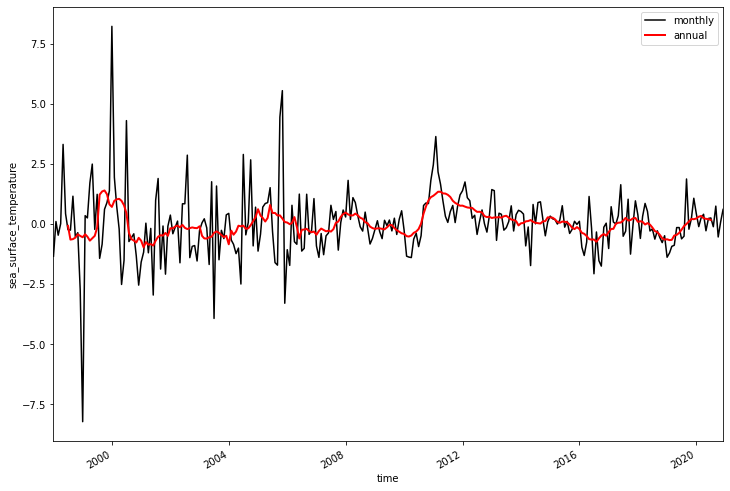

In [8]:
from intake_aodn.analysis import time_average, make_clim

# Make monthly anomalies
mn_ano = time_average(data,'M',var='sea_surface_temperature',ignore_inc = True).groupby('time.month') - make_clim(data['sea_surface_temperature'],time_res = 'month')[0]

# Compute box-averge and plot
bavg = mn_ano.stack(space=['longitude','latitude']).mean(dim='space')
fig = plt.figure(figsize=(12,8))
bavg.plot(label='monthly',color='black')

# Make yearly running anomalies on monthly timescale
yr_rol = bavg.rolling(time = 12, center=True).mean()

# plot smoothed timeseries
yr_rol.plot(label='annual',color='red',lw = 2)
plt.legend();

# fix xlim
xl = mn_ano.coords['time'].values
plt.xlim(xl.min(),xl.max())

The plot shows that monthly variability can be quite important compared to inter-annual variability, hence why smoothing can enhance important inter-annual patterns. 

***

## 5) Multi maps

Finally, we give the possibility to the user to make a publication-ready subplot map of a statistic of their data.  

The first step requires the user to define the data to plot. Let's imagine we want to plot monthly SST anomalies that we calculated in part 4, over a specific year.  
Once the data is ready, we simply have to call `multimap()` function, give it the dimension of the subplot panels and the number of columns we want:



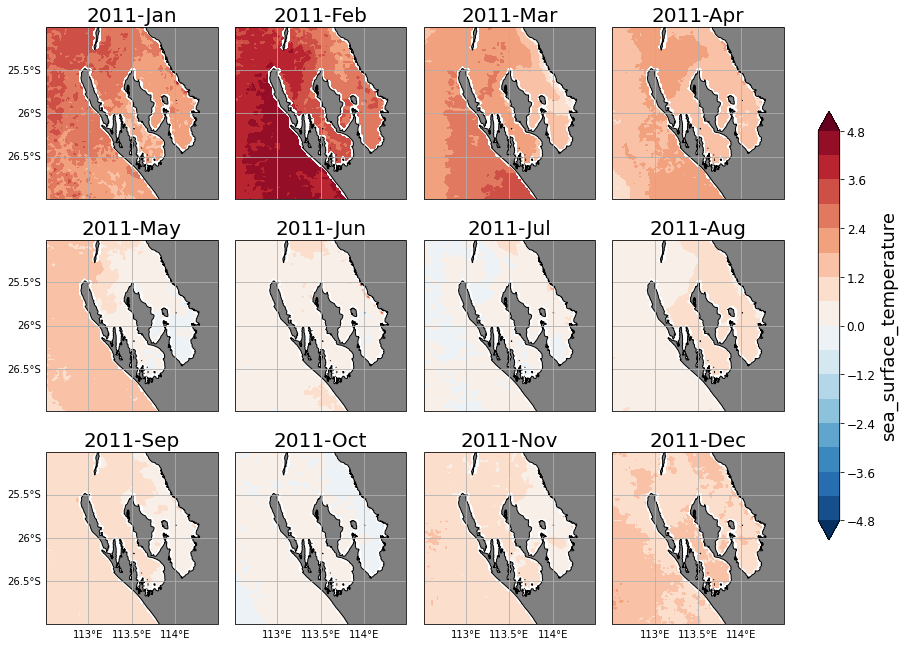

In [9]:
from intake_aodn.plot import multimap
import cmocean
from intake_aodn.analysis import time_average, make_clim

# Make monthly anomalies
da = time_average(data,'M',var='sea_surface_temperature',ignore_inc = True).groupby('time.month') - make_clim(data['sea_surface_temperature'],time_res = 'month')[0]

# data to plot
da = da.sel(time = slice('2011-01-01','2011-12-31'))

fig = multimap(da,col = 'time',col_wrap=4,freq = 'month')



***

## 6) Saving Figures

*But where is the save button!*  

I know, I did not place a save button. But remember, you can always save any image by right-clicking on it. We are working on a browser!  

Of course, we might want to save figures at a better quality, especially for publications. In reality, saving a plot is very easy, just insert the one-liner below at the end of any cell, chosing your file name, and format:

In [ ]:
plt.gcf().savefig("filename.changeformathere");#plt.gcf() indicates you want to save the latest figure.